In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import requests
from pprint import pprint
from datetime import datetime
import os
import csv

In [2]:
# Pull data from geojson file
yr = 2020
fire_gdf = gpd.read_file(f'../outputs/geojson/clean/ca_fire_{yr}.geojson').set_crs(4326)
fire_gdf.head()

,ALARM_DATE,CONT_DATE,CAUSE_ID,CAUSE,GIS_ACRES,AGENCY,FIRE_NAME,geometry
0,2020-06-18,2020-06-23,11,Powerline,109.60230,CDF,NELSON,"POLYGON ((-121.34842 38.88999, -121.34836 38.8..."
1,2020-06-01,2020-06-04,2,Equipment Use,685.58500,CDF,AMORUSO,"POLYGON ((-121.35276 38.82039, -121.35269 38.8..."
2,2020-08-10,2020-08-11,14,Unknown/Unidentified,27.30048,CDF,ATHENS,"POLYGON ((-121.33335 38.84558, -121.33312 38.8..."
3,2020-03-31,2020-04-01,9,Miscellaneous,12.93155,CDF,FLEMING,"POLYGON ((-121.27318 38.96308, -121.27306 38.9..."
4,2020-04-14,2020-04-19,18,Escaped Prescribed Burn,10.31596,CDF,MELANESE,"POLYGON ((-121.30067 39.48714, -121.30042 39.4..."


In [3]:
# Drop columns that are not needed
columns_to_drop = ['FIRE_NAME', 'AGENCY', 'geometry']
fire_gdf.drop(columns=columns_to_drop, inplace=True)

In [4]:
fire_gdf.head()

,ALARM_DATE,CONT_DATE,CAUSE_ID,CAUSE,GIS_ACRES
0,2020-06-18,2020-06-23,11,Powerline,109.60230
1,2020-06-01,2020-06-04,2,Equipment Use,685.58500
2,2020-08-10,2020-08-11,14,Unknown/Unidentified,27.30048
3,2020-03-31,2020-04-01,9,Miscellaneous,12.93155
4,2020-04-14,2020-04-19,18,Escaped Prescribed Burn,10.31596


In [5]:
# Change Dates columns to datetime format and objects
fire_gdf['CONT_DATE'] = pd.to_datetime(fire_gdf['CONT_DATE'])
fire_gdf['ALARM_DATE'] = pd.to_datetime(fire_gdf['ALARM_DATE'])
fire_gdf['Duration'] = fire_gdf['CONT_DATE'] - fire_gdf['ALARM_DATE']

In [6]:
fire_gdf.head()

,ALARM_DATE,CONT_DATE,CAUSE_ID,CAUSE,GIS_ACRES,Duration
0,2020-06-18,2020-06-23,11,Powerline,109.60230,5 days
1,2020-06-01,2020-06-04,2,Equipment Use,685.58500,3 days
2,2020-08-10,2020-08-11,14,Unknown/Unidentified,27.30048,1 days
3,2020-03-31,2020-04-01,9,Miscellaneous,12.93155,1 days
4,2020-04-14,2020-04-19,18,Escaped Prescribed Burn,10.31596,5 days


In [7]:
# Create empty lists to store avarage duration and average acres burn for each cause
average_duration = []
average_acres = []
cause_df = fire_gdf.sort_values(by='CAUSE_ID').reset_index()

# Create a function that takes in an integer and a dataframe
# Returns the average duration and average acres burn for a specific cause
def average_calc(i, df):
    test_df = df.loc[df['CAUSE_ID'] == i]
    days = []
    for d in test_df['Duration']:
        days.append(d.days)
    if len(days) != 0:
        average_d = round(sum(days)/len(days), 2)
    else:
        average_d = 0
    average_a = round(test_df['GIS_ACRES'].mean(),2)
    return average_d, average_a

# Loop to populate average duration and average acres lists
for i in cause_df['CAUSE_ID'].unique():
    d, a = average_calc(i, cause_df)
    average_duration.append(d)
    average_acres.append(a)
cause_list = cause_df['CAUSE'].unique()
cause_df.head()

,index,ALARM_DATE,CONT_DATE,CAUSE_ID,CAUSE,GIS_ACRES,Duration
0,218,2020-08-17,2020-09-11,1,Lightning,55208.9400,25 days
1,309,2020-06-24,2020-06-24,1,Lightning,116.1777,0 days
2,66,2020-06-17,2020-06-17,1,Lightning,421.4699,0 days
3,306,2020-06-26,2020-07-02,1,Lightning,238.2839,6 days
4,304,2020-08-18,2020-11-20,1,Lightning,4901.7270,94 days


In [8]:
# Get the count of the number of unique causes 
counts = cause_df.groupby('CAUSE_ID').size()

# Create new DataFrame showing the Causes, Average Duration, Average GIS Acres, and Number of Incidents for each cause
source_df = pd.DataFrame({'Causes' : cause_list, 
                          'Average Duration (days)' : average_duration, 
                          'Average GIS Acres' : average_acres,
                          'Number of Occurences (in the Year)' : counts})
source_df

,Causes,Average Duration (days),Average GIS Acres,Number of Occurences (in the Year)
CAUSE_ID,,,,
1,Lightning,27.26,36148.12,80
2,Equipment Use,2.66,669.72,65
3,Smoking,0.33,264.94,3
4,Campfire,3.11,489.58,9
5,Debris,0.64,28.35,22
7,Arson,6.33,251.43,24
8,Playing with fire,1.79,501.49,14
9,Miscellaneous,8.32,333.38,34
10,Vehicle,5.28,656.03,46


In [9]:
# Drop Miscellaneous and Unknown/Unidentified Rows
source_clean_df = source_df.drop(index = [9,14], inplace = False)

# Output the DataFrame to a csv file
source_clean_df.to_csv("outputs/fire_source_2020.csv",
                  encoding="utf-8", index=False, header=True)
source_clean_df

,Causes,Average Duration (days),Average GIS Acres,Number of Occurences (in the Year)
CAUSE_ID,,,,
1,Lightning,27.26,36148.12,80
2,Equipment Use,2.66,669.72,65
3,Smoking,0.33,264.94,3
4,Campfire,3.11,489.58,9
5,Debris,0.64,28.35,22
7,Arson,6.33,251.43,24
8,Playing with fire,1.79,501.49,14
10,Vehicle,5.28,656.03,46
11,Powerline,0.78,113.26,41


In [10]:
# Create a new DataFrame to compare Man-made fires vs. Natural fires
man_duration = 0
man_GIS_acres = 0
man_oc = 0
nat_duration = 0
nat_GIS_acres = 0
nat_oc = 0
for index, row in source_clean_df.iterrows():
    if row['Causes'] == 'Lightning':
        nat_duration += row['Average Duration (days)']
        nat_GIS_acres += row['Average GIS Acres']
        nat_oc += row['Number of Occurences (in the Year)']
    else:
        man_duration += row['Average Duration (days)'] 
        man_GIS_acres += row['Average GIS Acres']
        man_oc += row['Number of Occurences (in the Year)']

man_vs_nature_df = pd.DataFrame({'Causes':['Man-Made', 'Natural'], 
                                 'Average Duration (days)': [man_duration, nat_duration], 
                                 'Average GIS Acres': [man_GIS_acres, nat_GIS_acres],
                                 'Number of Occurences (in the Year)':[man_oc, nat_oc]
                                })
man_vs_nature_df

,Causes,Average Duration (days),Average GIS Acres,Number of Occurences (in the Year)
0,Man-Made,28.25,3227.79,228
1,Natural,27.26,36148.12,80


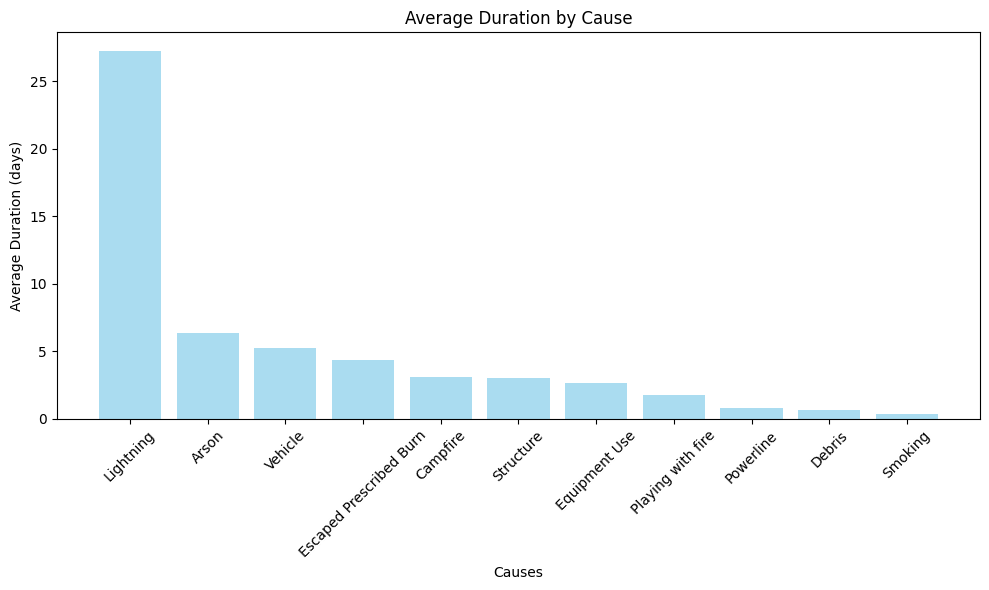

In [11]:
source_clean_df = source_clean_df.sort_values(by='Average Duration (days)', ascending=False)
plt.figure(figsize=(10, 6))

plt.bar(source_clean_df['Causes'], source_clean_df['Average Duration (days)'],
        color='skyblue', alpha=0.7)

plt.xlabel('Causes')
plt.ylabel('Average Duration (days)')
plt.title('Average Duration by Cause')

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

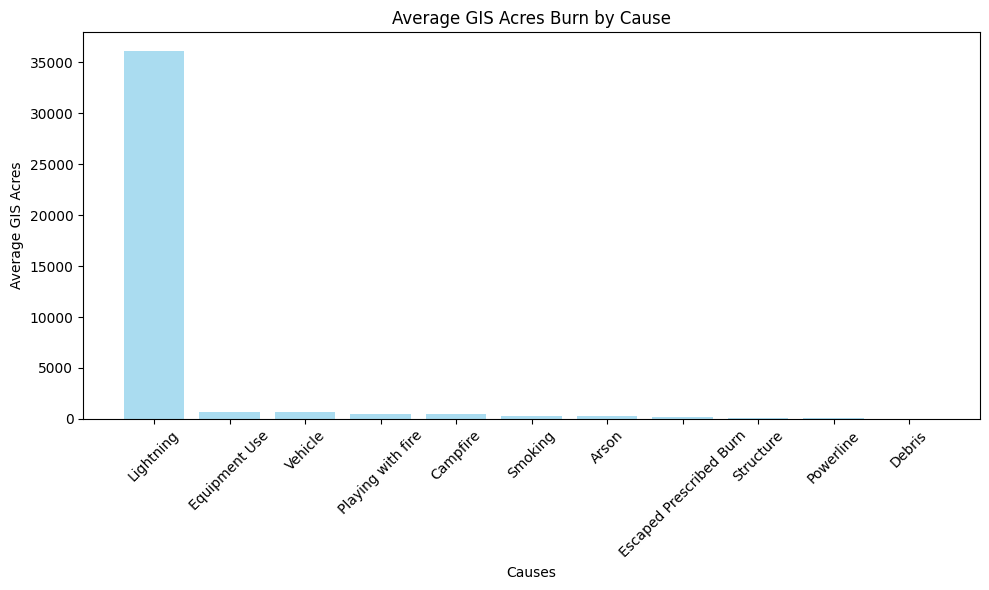

In [12]:
source_clean_df = source_clean_df.sort_values(by='Average GIS Acres', ascending=False)
plt.figure(figsize=(10, 6))

plt.bar(source_clean_df['Causes'], source_clean_df['Average GIS Acres'],
        color='skyblue', alpha=0.7)

plt.xlabel('Causes')
plt.ylabel('Average GIS Acres')
plt.title('Average GIS Acres Burn by Cause')

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

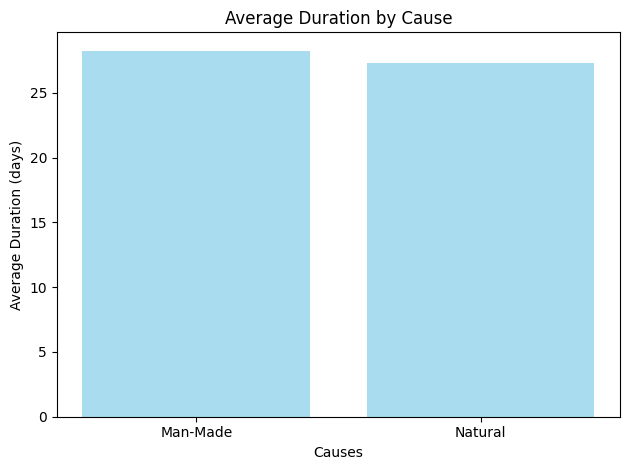

In [13]:
plt.bar(man_vs_nature_df['Causes'], man_vs_nature_df['Average Duration (days)'],
        color='skyblue', alpha=0.7)

plt.xlabel('Causes')
plt.ylabel('Average Duration (days)')
plt.title('Average Duration by Cause')

plt.tight_layout()
plt.show()

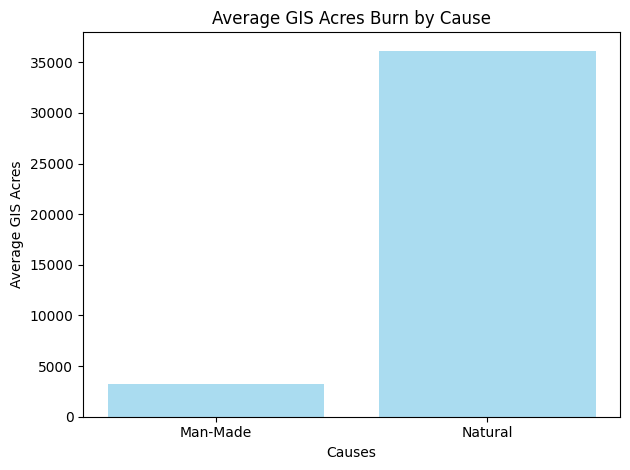

In [14]:
plt.bar(man_vs_nature_df['Causes'], man_vs_nature_df['Average GIS Acres'],
        color='skyblue', alpha=0.7)

plt.xlabel('Causes')
plt.ylabel('Average GIS Acres')
plt.title('Average GIS Acres Burn by Cause')

plt.tight_layout()
plt.show()

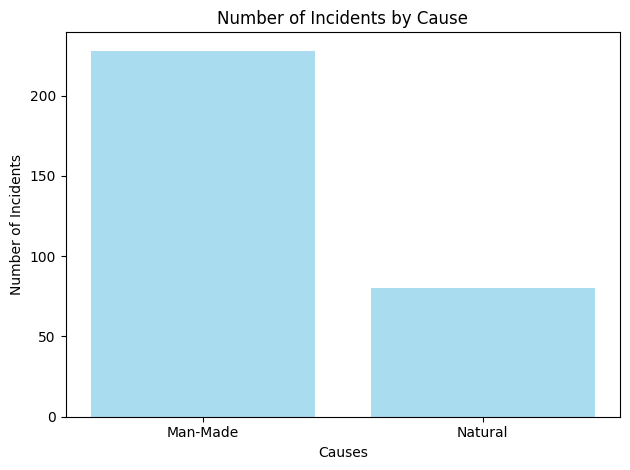

In [15]:
plt.bar(man_vs_nature_df['Causes'], man_vs_nature_df['Number of Occurences (in the Year)'],
        color='skyblue', alpha=0.7)

plt.xlabel('Causes')
plt.ylabel('Number of Incidents')
plt.title('Number of Incidents by Cause')

plt.tight_layout()
plt.show()

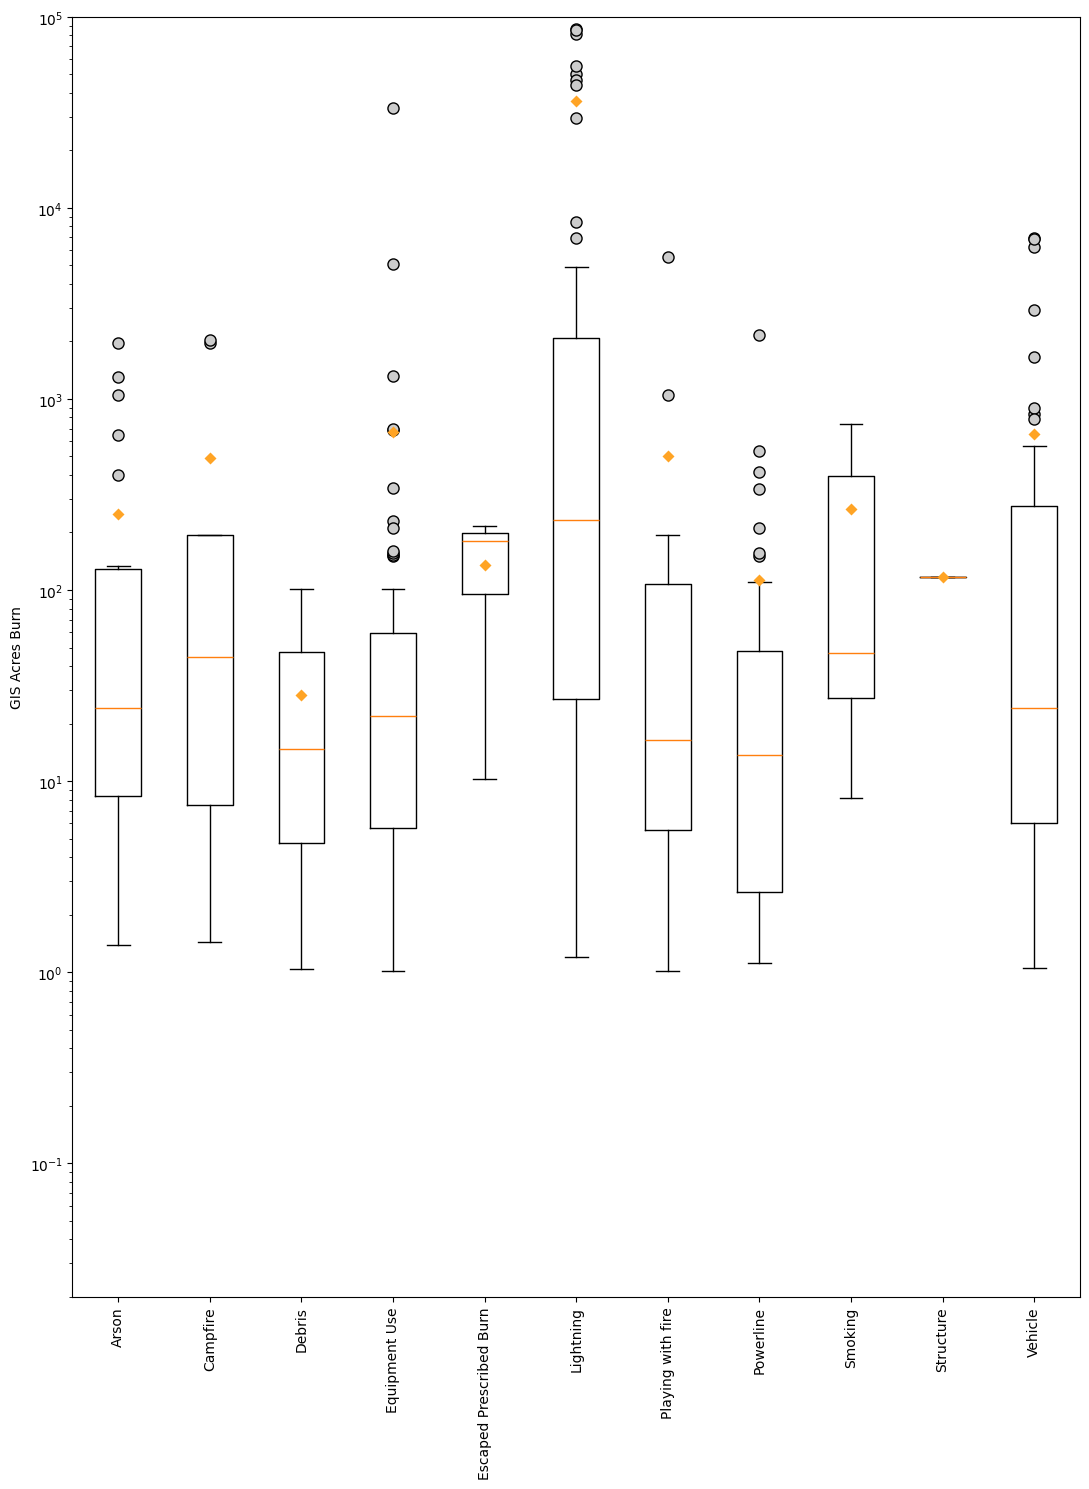

In [16]:
cause_list = fire_gdf['CAUSE'].unique()
value_to_remove = 'Miscellaneous'
new_arr = cause_list[cause_list != value_to_remove]
value_to_remove = 'Unknown/Unidentified'
cause_list = new_arr[new_arr != value_to_remove]
cause_gis = fire_gdf[fire_gdf['CAUSE'].isin(cause_list)]
grouped_data = cause_gis.groupby('CAUSE')['GIS_ACRES'].apply(list)

# # Create a box plot
# Highlight potential outliers by changing their color or style
plt.figure(figsize=(11,15))
meanprops = dict(marker='D', markeredgecolor='none',markerfacecolor='#ffa425')
plt.boxplot(grouped_data.values, tick_labels=grouped_data.index, showfliers=True, patch_artist=False, 
            flierprops=dict(marker='o', markerfacecolor='#ccc', markersize=8), meanprops = meanprops,showmeans = True
)

# Add labels and title
plt.ylim(0.02, 100000)
plt.xticks(rotation=90)
plt.ylabel('GIS Acres Burn')
plt.yscale('log')
plt.tight_layout()
plt.show()